## Step-by-step analysis

In [1]:
import epynet as en
wds = en.Network("anytown.inp")
# after the creation it automatically loads the network (load_network())

ObjectCollection class treats groups of elements as dictionaries. It returns pd.Series.

BaseObject: {
    Link: {
        Pump,
        Pipe,
        Valve
    };
    Node: {
        Reservoir,
        Junction,
        Tank
    }
}

Each componet has attributes, which have to be set before the simulation, and properties, which are modified with the simulation and can be retreived as _results_.

Pump attributes: { length, initstatus, speed } <br>
Pump properties: { flow, energy}



In [2]:
wds.pumps['78'].speed = 1.0
wds.pumps.speed

78    1.0
79    1.0
dtype: float64

In [3]:
wds.patterns['1'].values

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Let's try to create a random pattern to grasp how step-by-step simulation works.

In [4]:
import random
import pandas as pd 

custom_multipliers = []
for i in range(0, 24):
    custom_multipliers.append(round(random.uniform(0.5,1.5), 2))

custom_multipliers = pd.Series(custom_multipliers)

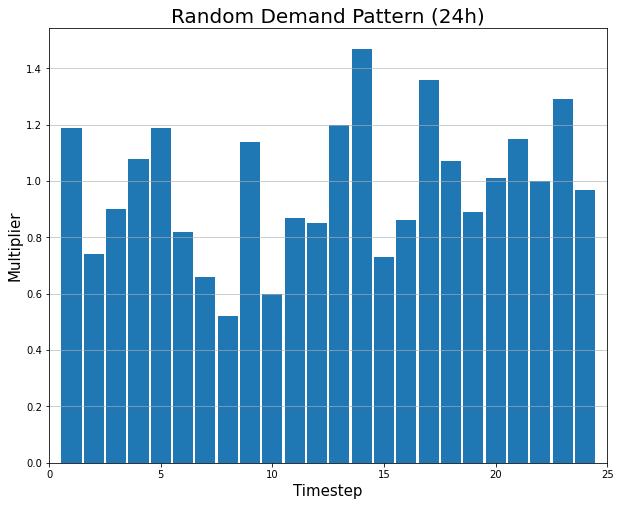

In [5]:
import matplotlib.pyplot as plt

#day_night_cycle = ['#e1f8ff', '#c9ebff', '#abb5ff', '#7475b6', '#5148b2']
plt.figure(figsize=[10,8])
plt.bar(x=range(1,25), height=custom_multipliers, width=0.9) 
plt.xlim(0, 25)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Timestep", fontsize=15)
plt.ylabel("Multiplier", fontsize=15)
plt.title("Random Demand Pattern (24h)", fontsize=20)
plt.show()

In [12]:
wds.add_pattern('2', custom_multipliers)

ENtoolkitError: Error 215: function call contains duplicate ID label

In [13]:
wds.patterns

{'1': <epynet.pattern.Pattern at 0x2994fa19088>,
 '4': <epynet.pattern.Pattern at 0x2994fa2d248>,
 '2': <epynet.pattern.Pattern at 0x2994fa7a148>}

In [14]:
for junc in wds.junctions:
    junc.pattern = 2
for junc in wds.junctions:
    print(junc.uid + ': ' + str(junc.pattern.index))

1: 2
2: 2
3: 2
4: 2
5: 2
6: 2
7: 2
8: 2
9: 2
10: 2
11: 2
12: 2
13: 2
14: 2
15: 2
16: 2
17: 2
18: 2
19: 2
20: 2
21: 2
22: 2


Now we need to set the time parameters, which are:
1. EN_DURATION: Total simulation duration.    
2. EN_HYDSTEP: Hydraulic time step. 
3. EN_QUALSTEP: Water quality time step. 
4. EN_PATTERNSTEP: Time pattern period. 
5. EN_PATTERNSTART: Time when time patterns begin. 
6. EN_REPORTSTEP: Reporting time step. 
7. EN_REPORTSTART: Time when reporting starts. 
8. EN_RULESTEP: Rule-based control evaluation time step. 
9. EN_STATISTIC: Reporting statistic code
10. EN_PERIODS: Number of reporting time periods (read only) 

Timevalue: value of time parameter in seconds


In [15]:
import utils

utils.time_parameters_summary(wds)

('EN_DURATION', 3600)
('EN_HYDSTEP', 60)
('EN_QUALSTEP', 3600)
('EN_PATTERNSTEP', 0)
('EN_PATTERNSTART', 3600)
('EN_REPORTSTEP', 0)
('EN_REPORTSTART', 6)
('EN_RULESTEP', 0)
('EN_STATISTIC', 0)
('EN_PERIODS', 64800)


In [21]:
wds.ep.ENsettimeparam(1, 3600)
wds.ep.ENsettimeparam(5, 1)

for i in range(0,20):
    wds.solve(i)
    print(str(i) + ": " + str(wds.junctions.pressure))

0: 1     86.223584
2     61.313746
3     60.089327
4     58.864908
5     48.953661
6     48.186415
7     48.040899
8     47.895383
9     34.494524
10    33.890095
11    34.396374
12    58.245221
13    61.465906
14    54.667822
15    57.080444
16    35.747431
17    33.215184
18    57.745103
19    57.369476
20    86.232836
21    54.349186
22    33.012032
dtype: float64
1: 1     86.223584
2     61.313746
3     60.089327
4     58.864908
5     48.953661
6     48.186415
7     48.040899
8     47.895383
9     34.494524
10    33.890095
11    34.396374
12    58.245221
13    61.465906
14    54.667822
15    57.080444
16    35.747431
17    33.215184
18    57.745103
19    57.369476
20    86.232836
21    54.349186
22    33.012032
dtype: float64
2: 1     86.223584
2     61.313746
3     60.089327
4     58.864908
5     48.953661
6     48.186415
7     48.040899
8     47.895383
9     34.494524
10    33.890095
11    34.396374
12    58.245221
13    61.465906
14    54.667822
15    57.080444
16    35.747431
1

In [22]:
wds.solve(2)
wds.pumps.flow

78    401.976202
79    401.976202
dtype: float64

In [32]:
wds.ep.ENsettimeparam(2, 4)
utils.time_parameters_summary(wds)

('EN_DURATION', 1)
('EN_HYDSTEP', 1)
('EN_QUALSTEP', 3600)
('EN_PATTERNSTEP', 2)
('EN_PATTERNSTART', 1)
('EN_REPORTSTEP', 0)
('EN_REPORTSTART', 6)
('EN_RULESTEP', 0)
('EN_STATISTIC', 0)
('EN_PERIODS', 64800)


In [25]:
wds.run()
wds.time

[0]

In [13]:
wds.pumps.flow

78    401.976202
79    401.976202
dtype: float64

In [33]:
def run_step_by_step:
    wds.reset()
    wds.time = []
    
    wds.ep.ENopenH()
    wds.ep.ENinitH(0)
    
    simtime = 0
    timestep = 1
    
    while timestep > 0:
        wds.ep.ENrunH()
        timestep = wds.ep.ENnextH()
        wds.time.append(simtime)
        wds.load_attributes(simtime)
        simtime += timestep


SyntaxError: invalid syntax (<ipython-input-33-457f91aa6888>, line 1)

In [ ]:
def get_junctions_head(wds : en.Network):
    return wds.junctions.head

In [ ]:
get_junctions_head(wds)